# Image Segmentation

In [5]:
import scipy.io
import math
import matplotlib.pyplot as plt
import matplotlib.image as img
import numpy as np
import sklearn.cluster as cluster
import sklearn.metrics.cluster as metrics
import os
import progressbar
from time import sleep
import distutils.dir_util

### 1. Download the dataset and understand the format (5 Points)

In [2]:
def read_images(path, format = 'jpg'):
    data = []
    ids = []
    for img in os.listdir(path):
        if (not img.endswith('.' + format)):
            continue
        image_path = os.path.join(path, img)
        image = plt.imread(image_path)
        data.append(image)
        ids.append(img.replace('.' + format,''))
    return data, ids

In [3]:
def read_ground_truths(path, ids):
    ground_truths = []
    for id_ in ids:
        mat = scipy.io.loadmat(path + "\\" + id_ + ".mat")
        img = [mat['groundTruth'][0][y][0][0]  for y in range(len(mat['groundTruth'][0]))]
        ground_truths.append(img)
    return ground_truths

In [4]:
train_data_path = "BSR_full/BSR/BSDS500/data/images/train"
val_data_path = "BSR_full/BSR/BSDS500/data/images/val"
test_data_path = "BSR_full/BSR/BSDS500/data/images/test"

train_ground_truths_path = "BSR_full/BSR/BSDS500/data/groundTruth/train"
val_ground_truths_path = "BSR_full/BSR/BSDS500/data/groundTruth/val"
test_ground_truths_path = "BSR_full/BSR/BSDS500/data/groundTruth/test"

# reading Data
train_data, train_ids = read_images(train_data_path)
val_data, val_ids = read_images(val_data_path)
test_data, test_ids = read_images(test_data_path)

# reading Ground Truths
train_ground_truths = read_ground_truths(train_ground_truths_path, train_ids)
val_ground_truths = read_ground_truths(val_ground_truths_path, val_ids)
test_ground_truths = read_ground_truths(test_ground_truths_path, test_ids)

### 2. Visualize the image and the ground truth segmentation (5 points)

In [22]:
def display(id_num, split = 'train', num = math.inf, k = 5):
    
    images, ground_truths, predictions = {}, {}, {}
    images['train'], ground_truths['train'], predictions['train'] = train_data, train_ground_truths, train_clustering
    images['val'], ground_truths['val'] = val_data, val_ground_truths
    images['test'], ground_truths['test'] = test_data, test_ground_truths
    
    plt.figure()
    plt.imshow(images[split][id_num])
    plt.figure()
    plt.imshow(predictions[split][k][id_num])
    for i in range(min(len(ground_truths[split][id_num]), num)):
        plt.figure()
        plt.imshow(ground_truths[split][id_num][i][0])

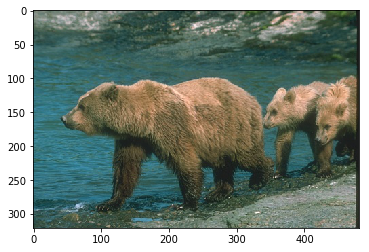

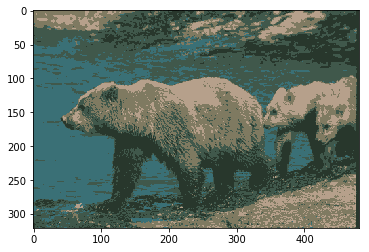

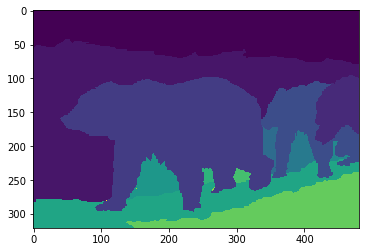

In [23]:
display(0, num = 1)

### 3. Segmentation using K-means (15 Points)(your implementation)

In [7]:
class KMeans:
    def __init__(self, n_clusters = 5, n_restarts = 3, max_iter = 50, epsilon = 0.0001):
        self.n_clusters = n_clusters
        self.n_restarts = n_restarts
        self.max_iter = max_iter
        self.epsilon = epsilon
        self.X_train = None
        self.centroids = None
        self.cluster_assignments = None
        self.statistics = {
            'inertia': np.zeros((self.n_restarts, self.max_iter)),
            'variances': np.zeros((self.n_restarts, self.max_iter, self.n_clusters))
        }
        
    def fit(self, X_train):
        self.X_train = X_train
        self.cluster_assignments = np.zeros(self.X_train.shape[0])
        
        for restart in np.arange(self.n_restarts):
            self.init_centroids()
            for it in np.arange(self.max_iter):
                self.statistics['inertia'][restart, it] = self.assign_clusters()
                #self.statistics['variances'][restart, it, :] = self.compute_centroids()
                ## Add Stopping condition based on epsilon
     
    def init_centroids(self):
        random_indices = np.random.choice(self.X_train.shape[0], self.n_clusters)
        self.centroids = self.X_train[random_indices]
        
    def assign_clusters(self):
        distances = np.zeros((self.X_train.shape[0], self.n_clusters))
        min_distances = np.zeros(self.X_train.shape[0])
        for eg in np.arange(self.X_train.shape[0]):
            distances[eg] = np.linalg.norm(self.X_train[eg] - self.centroids, axis = 1)
            min_distances[eg], self.cluster_assignments[eg] = np.min(distances[eg]), np.argmin(distances[eg])
        return np.sum(min_distances)
    
    def compute_centroids(self):
        variances = np.zeros(self.n_clusters)
        for k in np.arange(self.n_clusters):
            self.centroids[k] = np.mean(self.X_train[self.cluster_assignments==k], axis = 0)
            variances[k] = np.var(self.X_train[self.cluster_assignments==k], axis = 0)
        return variances    
                

##### a. We will change the K of the K-means algorithm between {3,5,7,9,11} clusters. You will produce different segmentations and save them as colored images. Every color represents a certain group (cluster) of pixels.

In [8]:
k_values = [3, 5, 7, 9, 11]
kmeans_classes = {}
for k in k_values:  
    kmeans_classes[k] = cluster.KMeans(n_clusters = k) 

In [9]:
def init_directories():
    for k in k_values:
        for t in ['spatial', 'normal']:
            distutils.dir_util.mkpath('results/images/' + t +'/' + str(k)) 
            distutils.dir_util.mkpath('results/mat_files/' + t +'/' + str(k)) 

In [11]:
def segment(data, ids, start = 0, end = None, behaviour = 'normal'):
    
    if end == None:
        end = len(data)
    init_directories()

    for k in k_values:
        for image, i in zip(progressbar.progressbar(data[start:end]), range(start, end)):
            
            image = np.array(image)
            h, w, _ = image.shape
            x_image = image.reshape((h * w, 3))
            normalization_parameters = np.array([255, 255, 255])
            
            if behaviour == 'spatial':
                x_image = np.append(x_image, [(x, y) for x in range(h) for y in range(w)], axis = 1)
                normalization_parameters = np.array([255, 255, 255, h, w])
            
            x_image = x_image / normalization_parameters
            
            kmeans = kmeans_classes[k].fit(x_image)
            y = (kmeans.cluster_centers_[:, 0:3][kmeans.labels_] * 255).reshape((h, w, 3)).astype(np.uint8)
            
            image_save_path = 'results/images/' + behaviour + '/' + str(k) + '/' + str(ids[i]) + '.png'
            plt.imsave(image_save_path, y, format = 'png')    
                       
            mat = {}
            mat['labels'] = kmeans.labels_
            
            mat_save_path = 'results/mat_files/' + behaviour + '/' + str(k) + '/' + str(ids[i]) + '.mat'
            scipy.io.savemat(mat_save_path, mat)
        

In [ ]:
segment(train_data, train_ids, start = 0, end = 5)

In [ ]:
segment(train_data, train_ids, start = 50, end = 100)

In [ ]:
segment(train_data, train_ids, start = 100, end = 150)

In [ ]:
segment(train_data, train_ids, start = 150, end = 200)

#### b. We will evaluate the result segmentation using F-measure, Conditional Entropy. for image I with M available ground-truth segmentations. For a clustering of K-clusters you will report your measures M times and the average of the M trials as well. Report average per dataset as well.

In [12]:
def load_mat_files(path):
    files = []
    ids = []
    for file in os.listdir(path):
        file_path = os.path.join(path, file)
        mat_file = scipy.io.loadmat(file_path)
        files.append(mat_file)
        ids.append(file.replace('.mat',''))
    return files, ids

In [13]:
train_results = {}
train_results_ids = {}

for k in k_values:
    path = "results/mat_files/normal/" + str(k)
    train_results[k], train_results_ids[k] = load_mat_files(path)

In [14]:
train_clustering = {}
train_clustering_ids = {}

for k in k_values:
    path = "results/images/normal/" + str(k)
    train_clustering[k], train_clustering_ids[k] = read_images(path, 'png')

In [15]:
def f1_score(true_labels, predicted_labels):
    matrix = metrics.contingency_matrix(true_labels, predicted_labels)
    precision = np.max(matrix / np.sum(matrix, axis = 0), axis = 0)
    recall = np.max(matrix, axis = 0) / np.sum(matrix[np.argmax(matrix, axis = 0)], axis = 1)
    f1_score = np.mean( (2 * precision * recall)/(precision + recall))
    return f1_score

In [16]:
def entropy(true_labels, predicted_labels, epsilon = 1e-300):
    matrix = metrics.contingency_matrix(true_labels, predicted_labels) + epsilon
    p = matrix / np.sum(matrix, axis = 0)
    entropy = -np.sum(p * np.log(p), axis = 0) * (np.sum(matrix, axis = 0) / np.sum(matrix))
    return np.sum(entropy)

In [17]:
f1_scores_avg, entropy_scores_avg = {}, {}

for k in k_values:
    avg_f1, avg_entropy = [], []
    for result, i in zip(progressbar.progressbar(train_results[k]), range(len(train_results[k]))):
        eg_f1_avg, eg_entropy_avg = [], []
        prediction = result['labels'][0]
        for ground_truth in train_ground_truths[i]:
            true_labels = ground_truth[0].reshape(np.product(ground_truth[0].shape))
            eg_f1_avg.append(f1_score(true_labels, prediction))
            eg_entropy_avg.append(entropy(true_labels, prediction))
        avg_f1.append(np.mean(eg_f1_avg))
        avg_entropy.append(np.mean(eg_entropy_avg))
    f1_scores_avg[k] = np.mean(avg_f1)
    entropy_scores_avg[k] = np.mean(avg_entropy)
    
print("F1 scores: ", f1_scores_avg)
print("Entropy: ", entropy_scores_avg)

100% (200 of 200) |######################| Elapsed Time: 0:00:28 Time:  0:00:28
100% (200 of 200) |######################| Elapsed Time: 0:00:29 Time:  0:00:29
100% (200 of 200) |######################| Elapsed Time: 0:00:30 Time:  0:00:30
100% (200 of 200) |######################| Elapsed Time: 0:00:27 Time:  0:00:27
100% (200 of 200) |######################| Elapsed Time: 0:00:28 Time:  0:00:28


F1 scores:  {3: 0.5336790131119092, 5: 0.4542495460165536, 7: 0.3941966333208589, 9: 0.3496508695276296, 11: 0.3161629274760092}
Entropy:  {3: 1.2687172927512789, 5: 1.1506589083038061, 7: 1.0892212099299405, 9: 1.0461101043470407, 11: 1.0106956400425822}


### 4. Big Picture (10 Points)
##### a. Select a set of five images and display their corresponding ground truth against your segmentation results using K-means at K=5. Comment on the results.

In [18]:
sample = np.random.choice(range(200), 5)

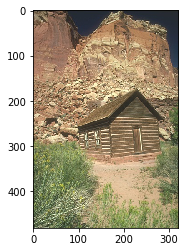

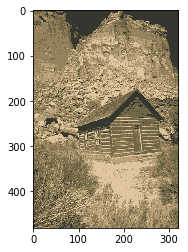

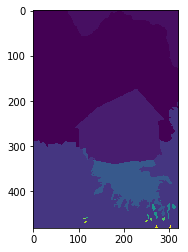

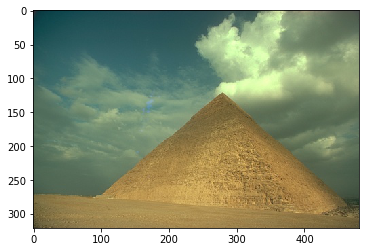

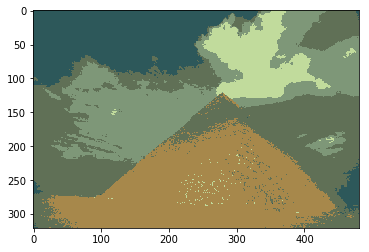

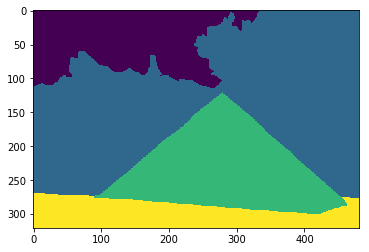

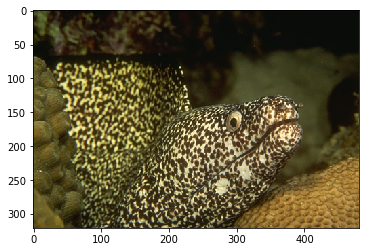

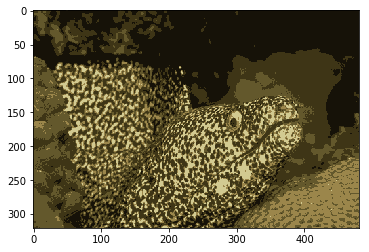

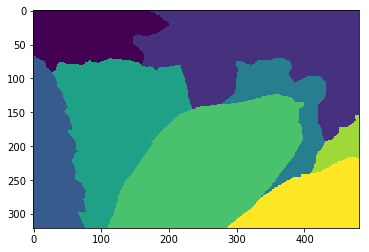

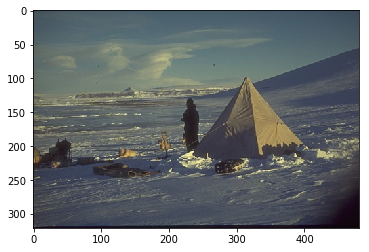

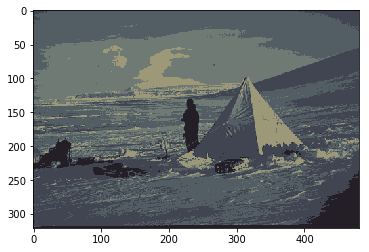

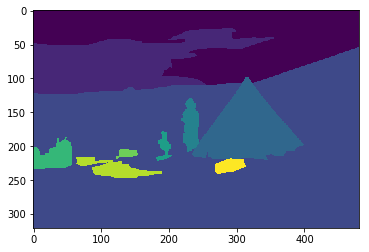

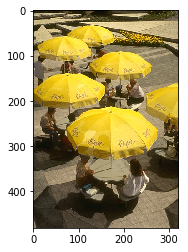

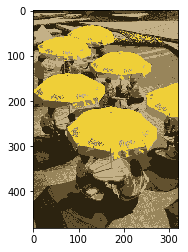

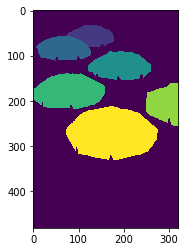

In [25]:
images_sample = np.array(train_data)[sample]
clustering_sample = np.array(train_clustering[5])[sample]
ground_truth_sample = np.array(train_ground_truths)[sample]


for image in sample:
    display(image, num = 1)

##### b. Select the same five images and display their corresponding ground truth against your segmentation results using Normalized-cut for the 5-NN graph, at K=5. Comment on the results.

In [ ]:
results = []
spectral = cluster.SpectralClustering(n_clusters = 5, affinity = 'nearest_neighbors', n_neighbors = 5)
for image in progressbar.progressbar(images_sample):
    image = np.array(image)
    h, w, _ = image.shape
    x_image = image.reshape((h * w, 3))
    results.append(spectral.fit(x_image).labels_.reshape((h, w, 3)))

### Extra(10 Points)

In [ ]:
segment(train_data, train_ids, start = 0, end = 200, spatial = True)

## tests w kda

In [ ]:
image = np.array(images_sample[0])
h, w, _ = image.shape
x_image = image.reshape((h * w, 3))
cluster.SpectralClustering(n_clusters = 5, n_neighbors = 5, affinity = 'nearest_neighbors', n_jobs = 4).fit(x_image)

In [ ]:
display_train(0)

In [ ]:
image = np.array(train_data[15])
#plt.imshow(image)
h, w, _ = image.shape
example = image.reshape((h * w, 3))
new = example

In [ ]:
xy = [(x, y) for x in range(h) for y in range(w)]
new = np.append(example, xy, axis = 1)
weight = 1
new = new / np.array([255, 255, 255, weight * h, weight * w])

In [ ]:
skl.KMeans(n_clusters = 7).fit(new)

In [ ]:
clusters = hg.cluster_centers_[:, 0:3]

In [ ]:
z = clusters[hg.labels_] * 255
x = example
plt.imshow(z.reshape((h, w ,3)))

In [ ]:
#display_train(10)

In [ ]:
mat = scipy.io.loadmat("BSR_full/BSR/BSDS500/data/groundTruth/train/12003.mat")
p = mat['groundTruth'].reshape((5))
print(p.shape)
plt.imshow(p[3][0][0][0])

In [ ]:
%timeit kmeans = skl.KMeans(n_clusters = 11, ).fit(x_image)

In [ ]:
%timeit kmeans = skl.KMeans(n_clusters = 9, max_iter = 50).fit(x_image)

In [ ]:
%timeit kmeans = skl.KMeans(n_clusters = 7).fit(x_image)

In [ ]:
%timeit kmeans = skl.KMeans(n_clusters = 5).fit(x_image)

In [ ]:
%timeit kmeans = skl.KMeans(n_clusters = 3).fit(x_image)

In [ ]:

for i in progressbar.progressbar(range(20)):
    sleep(0.2)

In [ ]:
np.product((3, 5))

In [ ]:
x = np.array([[1],[2],[3]])
y = np.array([[1],[2],[3]])
x * y

In [25]:
x = np.array([1, 2, 1, 3, 2])

In [14]:
x = [x] * len(x)

In [35]:
x.size

5

In [37]:
np.equal(x, x.reshape((x.size,1)))

array([[ True, False,  True, False, False],
       [False,  True, False, False,  True],
       [ True, False,  True, False, False],
       [False, False, False,  True, False],
       [False,  True, False, False,  True]])

In [32]:
x

array([1, 2, 1, 3, 2])

array([[1],
       [2],
       [1],
       [3],
       [2]])